In [8]:
import numpy as np
import pandas as pd
from pandas import Series
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score, GridSearchCV, train_test_split
from sklearn.metrics import roc_curve,auc,roc_auc_score,confusion_matrix
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from xgboost import XGBClassifier
%matplotlib inline

In [2]:
classes = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']

In [3]:
train = pd.read_csv('/Users/nikmag/Desktop/USC/INF_552_ML/Project/Data/train.csv').fillna(' ')
test = pd.read_csv('/Users/nikmag/Desktop/USC/INF_552_ML/Project/Data/test.csv').fillna(' ')

In [4]:
train.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


In [4]:
for class_ in classes:
    print(r'Event rate for %s' % class_)
    print(str(np.round(float(train[class_].value_counts()[1]*100)/len(train),2))+'%')

Event rate for toxic
9.58%
Event rate for severe_toxic
1.0%
Event rate for obscene
5.29%
Event rate for threat
0.3%
Event rate for insult
4.94%
Event rate for identity_hate
0.88%


In [5]:
text = pd.concat([train['comment_text'],test['comment_text']]).reset_index(drop=True)

In [6]:
tfidf = TfidfVectorizer(
    sublinear_tf=True,
    strip_accents='unicode',
    analyzer='word',
    token_pattern=r'[a-z]{3,}',
    stop_words='english',
    ngram_range=(1, 2),
    max_df = 50000,
    max_features=300)

tfidf.fit(text)
train_features = tfidf.transform(train['comment_text'])

In [7]:
X_train, X_test, y_train, y_test = train_test_split(train_features.toarray(), train[classes], test_size=0.3, random_state=0)

### Logistic Regression

CV Score for toxic = 0.892022095095
CV Score for severe_toxic = 0.966332925444
CV Score for obscene = 0.936690272751
CV Score for threat = 0.925615170006
CV Score for insult = 0.914895864574
CV Score for identity_hate = 0.925681389345


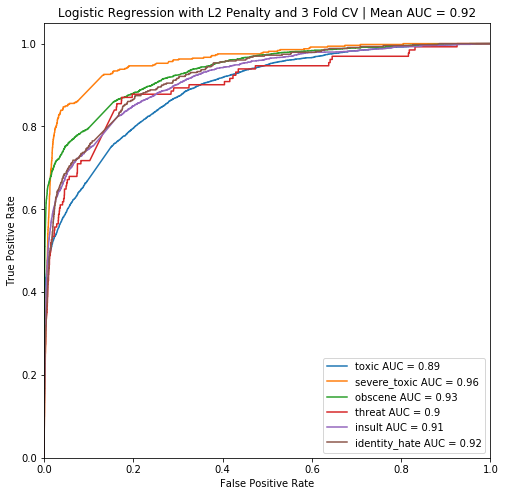

In [61]:
d = {k:[] for k in y_test.columns.tolist()}
plt.figure(0,figsize=(8,8)).clf()
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
avg_auc = 0
for class_ in classes:
    logR = LogisticRegression(solver='sag',penalty='l2')
    model = GridSearchCV(estimator=logR,cv=3,param_grid={'C':[0.01,0.1,1,10]},scoring='roc_auc')
    model.fit(X_train, y_train[class_])
    print('CV Score for {} = {}'.format(class_, model.best_score_))
    prediction = model.predict_proba(X_test)
    actual = y_test[class_]
    fpr, tpr, threshold = roc_curve(actual,prediction[:,1])
    d[class_] = d[class_] + np.where(prediction[:,1]>=threshold[np.argmax(tpr-fpr)],1,0).tolist()
    AUC = np.round(roc_auc_score(actual,prediction[:,1]),2)
    avg_auc = avg_auc + AUC
    plt.plot(fpr,tpr,label=class_+" AUC = "+str(AUC))
    plt.legend(loc="lower right")
plt.title('Logistic Regression with L2 Penalty and 3 Fold CV | Mean AUC = {}'.format(np.round(float(avg_auc)/6.0,2)))
y_pred = pd.DataFrame(d)
y_true = y_test.reset_index(drop=True)
match = {k:object for k in ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']}
for i in ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']:
    match[i] = np.where(y_true[i] == y_pred[i],1,0)

df_match = pd.DataFrame(match)

df_match['sum'] = df_match[['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']].sum(axis=1)
df_match['hamming_match'] = df_match['sum'].astype(float)/6.0

In [62]:
print('hamming score = %s' % str(np.round(df_match['hamming_match'].sum(axis=0)/len(df_match),2)))

hamming score = 0.87


### Random Forest

toxic
severe_toxic
obscene
threat
insult
identity_hate


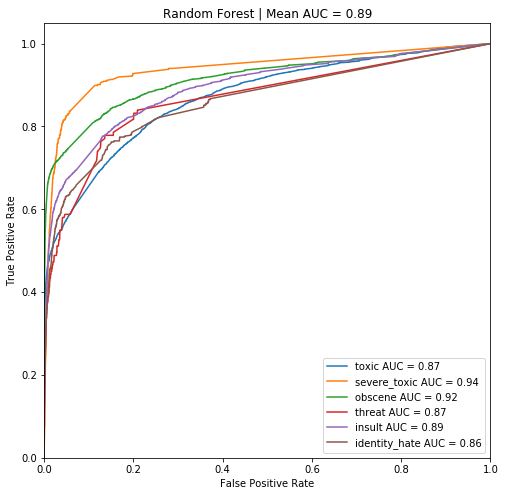

In [95]:
d = {k:[] for k in y_test.columns.tolist()}
plt.figure(0,figsize=(8,8)).clf()
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
avg_auc = 0
for class_ in classes:
    print(class_)
    model = RandomForestClassifier(n_estimators=1000,n_jobs=2,oob_score=True,)
    model.fit(X_train, y_train[class_])
    prediction = model.predict_proba(X_test)
    actual = y_test[class_]
    fpr, tpr, threshold = roc_curve(actual,prediction[:,1])
    d[class_] = d[class_] + np.where(prediction[:,1]>=threshold[np.argmax(tpr-fpr)],1,0).tolist()
    AUC = np.round(roc_auc_score(actual,prediction[:,1]),2)
    avg_auc = avg_auc + AUC
    plt.plot(fpr,tpr,label=class_+" AUC = "+str(AUC))
    plt.legend(loc="lower right")
plt.title('Random Forest | Mean AUC = {}'.format(np.round(float(avg_auc)/6.0,2)))
y_pred = pd.DataFrame(d)
y_true = y_test.reset_index(drop=True)
match = {k:object for k in ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']}
for i in ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']:
    match[i] = np.where(y_true[i] == y_pred[i],1,0)
df_match = pd.DataFrame(match)
df_match['sum'] = df_match[['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']].sum(axis=1)
df_match['hamming_match'] = df_match['sum'].astype(float)/6.0

In [150]:
print('hamming score = %s' % str(np.round(df_match['hamming_match'].sum(axis=0)/len(df_match),2)))

hamming score = 0.86


In [141]:
fimp = pd.DataFrame({'vars':[features[i] for i in indices],'imp':[importances[i] for i in indices]}).sort_values(by=['imp'],ascending=False)

In [146]:
fimp.index = fimp['vars']

Text(0.5,0,u'Relative Importances')

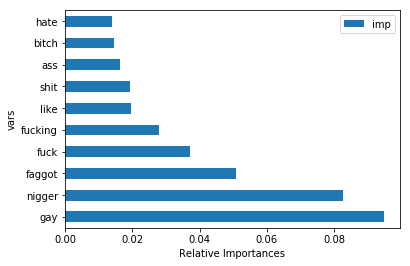

In [149]:
ax = fimp.plot(kind='barh')
ax.set_xlabel("Relative Importances")

### XGBoost

toxic
severe_toxic
obscene
threat
insult
identity_hate


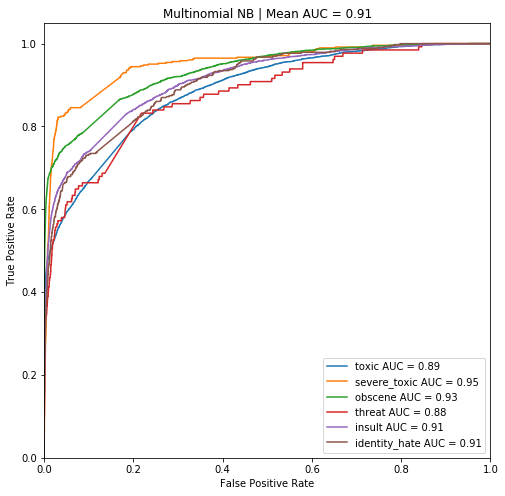

In [10]:
d = {k:[] for k in y_test.columns.tolist()}
plt.figure(0,figsize=(8,8)).clf()
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
avg_auc = 0
for class_ in classes:
    print(class_)
    model = XGBClassifier(n_estimators=500,n_jobs=2,oob_score=True)
    model.fit(X_train, y_train[class_])
    prediction = model.predict_proba(X_test)
    actual = y_test[class_]
    fpr, tpr, threshold = roc_curve(actual,prediction[:,1])
    d[class_] = d[class_] + np.where(prediction[:,1]>=threshold[np.argmax(tpr-fpr)],1,0).tolist()
    AUC = np.round(roc_auc_score(actual,prediction[:,1]),2)
    avg_auc = avg_auc + AUC
    plt.plot(fpr,tpr,label=class_+" AUC = "+str(AUC))
    plt.legend(loc="lower right")
plt.title('Multinomial NB | Mean AUC = {}'.format(np.round(float(avg_auc)/6.0,2)))
y_pred = pd.DataFrame(d)
y_true = y_test.reset_index(drop=True)
match = {k:object for k in ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']}
for i in ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']:
    match[i] = np.where(y_true[i] == y_pred[i],1,0)
df_match = pd.DataFrame(match)
df_match['sum'] = df_match[['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']].sum(axis=1)
df_match['hamming_match'] = df_match['sum'].astype(float)/6.0

In [11]:
print('hamming score = %s' % str(np.round(df_match['hamming_match'].sum(axis=0)/len(df_match),2)))

hamming score = 0.87


### Multinomial Naive Bayes

toxic
severe_toxic
obscene
threat
insult
identity_hate


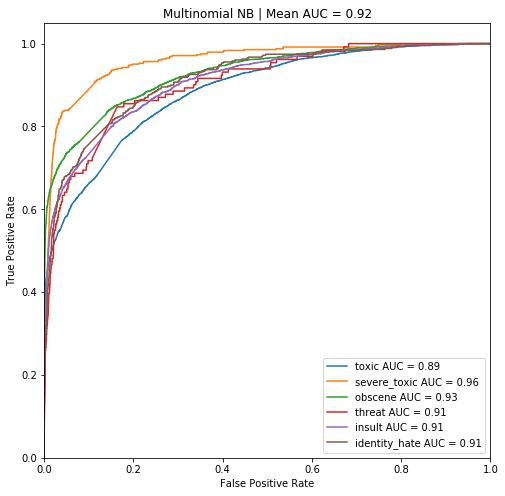

In [9]:
d = {k:[] for k in y_test.columns.tolist()}
plt.figure(0,figsize=(8,8)).clf()
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
avg_auc = 0
for class_ in classes:
    print(class_)
    model = MultinomialNB()
    model.fit(X_train, y_train[class_])
    prediction = model.predict_proba(X_test)
    actual = y_test[class_]
    fpr, tpr, threshold = roc_curve(actual,prediction[:,1])
    d[class_] = d[class_] + np.where(prediction[:,1]>=threshold[np.argmax(tpr-fpr)],1,0).tolist()
    AUC = np.round(roc_auc_score(actual,prediction[:,1]),2)
    avg_auc = avg_auc + AUC
    plt.plot(fpr,tpr,label=class_+" AUC = "+str(AUC))
    plt.legend(loc="lower right")
plt.title('Multinomial NB | Mean AUC = {}'.format(np.round(float(avg_auc)/6.0,2)))
y_pred = pd.DataFrame(d)
y_true = y_test.reset_index(drop=True)
match = {k:object for k in ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']}
for i in ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']:
    match[i] = np.where(y_true[i] == y_pred[i],1,0)
df_match = pd.DataFrame(match)
df_match['sum'] = df_match[['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']].sum(axis=1)
df_match['hamming_match'] = df_match['sum'].astype(float)/6.0

In [10]:
print('hamming score = %s' % str(np.round(df_match['hamming_match'].sum(axis=0)/len(df_match),2)))

hamming score = 0.86
